In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from numpy.random import randint
from IPython.display import display

In [2]:
# calculate value of target function.
def target_func(x, r, mu, c, Sig, b, lambd):
    # if some element of x is negative, return np.inf.
    if np.sum(x>0) < x.shape[0]:
        return np.inf

    # else, return the corresponding result.
    R = -np.dot(x.T, mu-r) + c*np.sqrt(np.dot(x.T, np.dot(Sig, x)))
    return R - lambd*np.sum(b*np.log(x))


# gradient descent for one single index
def CD_single_index(i, r, mu, c, Sig, b, lambd, x):

    # compute the two terms on the numerator separately.
    term1 = 0
    for j in range(mu.shape[0]):
        if j == i:
            continue
        else:
            term1 += x[j]*Sig[i][j]
    term1 *= (-c)

    pi = mu-r
    sig = np.sqrt(float(np.dot(x.T, np.dot(Sig, x))))
    term1 += pi[i]*sig

    term2 = np.sqrt(np.square(term1)+4*lambd*c*b[i]*Sig[i][i]*sig)
    
    # update index i element in x and return.
    res = np.array(x)
    res[i] = (term1+term2)/(2*c*Sig[i][i])
    return res

In [3]:
def RB_unconstrianed(r, mu, c, Sig, b, lambd=1, eta=0.1, opt_algo='CCD', max_iter=10000, prec=1e-6):
    
    # check if optimization algo type is one of these three.
    # if not, raise error.
    if opt_algo not in ['Newton', 'RCD', 'CCD']:
        raise ValueError('Optimization algo type is not correct.')
    
    # get starting time point.
    start_time = datetime.datetime.now()
    
    
    # Newton algorithm
    if opt_algo == 'Newton':
        # starting point of x: all elements are 1.
        x_next = np.ones(shape=(mu.shape[0], 1))
        
        # descent in a quadratic way step by step.
        for iter in range(max_iter):
            x_prev = x_next
            
            # we will compute Sigma*x and store it
            # since we will use it many times.
            Sig_mul_x = np.dot(Sig, x_prev)
            
            # compute sigma=x.T*Sigma*x
            # since we will use it many times.
            sig = np.sqrt(float(np.dot(x_prev.T, Sig_mul_x)))
            
            # compute gradient and Hessian at x_prev.
            grad = -(mu-r) + c*Sig_mul_x/sig - lambd*b/x_prev
            
            hessian = c * (Sig*sig-np.dot(Sig_mul_x, Sig_mul_x.T)) / np.square(sig)\
                      + lambd*np.diag(b/np.square(x_prev))
            
            # descent for one time.
            x_next = x_prev-eta*np.dot(np.linalg.inv(hessian), grad)
            
            # if two adjacent results are close, return.
            target_val_prev = target_func(x_prev, r, mu, c, Sig, b, lambd)
            target_val_next = target_func(x_next, r, mu, c, Sig, b, lambd)
            
            if np.abs((target_val_next-target_val_prev)/target_val_prev) <= prec:
                end_time = datetime.datetime.now()
                return {'x_opt':x_next, 'target value':target_val_next, 'iter_num':iter, 'time in mu s':(end_time-start_time).microseconds}
        
        # else stop running and return time-out indicator.
        end_time = datetime.datetime.now()
        return {'x_opt':'time out', 'target value':target_val_next, 'iter_num':iter, 'time in mu s':(end_time-start_time).microseconds}
    
    
    # RCD algorithm
    if opt_algo == 'RCD':
        
        asset_num = mu.shape[0]  # number of assets
        # starting point of x: all elements are 1.
        x_next = np.ones(shape=(asset_num, 1))
        
        for iter in range(max_iter):
            # traget function value before this round of descending
            target_val_prev = target_func(x_next, r, mu, c, Sig, b, lambd)
            
            # run coordinate gradient descent for asset_num times.
            for _ in range(asset_num):
                opt_idx = randint(low=0, high=asset_num)
                x_prev = x_next
                x_next = CD_single_index(opt_idx, r, mu, c, Sig, b, lambd, x_prev)
            
            # target function value after this round of descending
            target_val_next = target_func(x_next, r, mu, c, Sig, b, lambd)
            
            # if two adjacent results are close, return.
            if np.abs((target_val_next-target_val_prev)/target_val_prev) <= prec:
                end_time = datetime.datetime.now()
                return {'x_opt':x_next, 'target value':target_val_next, 'iter_num':iter, 'time in mu s':(end_time-start_time).microseconds}
        
        # else stop running and return time-out indicator.
        end_time = datetime.datetime.now()
        return {'x_opt':'time out', 'target value':target_val_next, 'iter_num':iter, 'time in mu s':(end_time-start_time).microseconds}
    
    
    # CCD algorithm
    if opt_algo == 'CCD':
        
        asset_num = mu.shape[0]  # number of assets
        # starting point of x: all elements are 1.
        x_next = np.ones(shape=(asset_num, 1))
        
        for iter in range(max_iter):
            # target function value before this round of descending
            target_val_prev = target_func(x_next, r, mu, c, Sig, b, lambd)
            
            # run coordinate gradient descent for each index.
            for idx in range(asset_num):
                x_prev = x_next
                x_next = CD_single_index(idx, r, mu, c, Sig, b, lambd, x_prev)
            
            # target function value after this round of descending
            target_val_next = target_func(x_next, r, mu, c, Sig, b, lambd)
            
            # if two adjacent results are close, return.
            if np.abs((target_val_next-target_val_prev)/target_val_prev) <= prec:
                end_time = datetime.datetime.now()
                return {'x_opt':x_next, 'target value':target_val_next, 'iter_num':iter, 'time in mu s':(end_time-start_time).microseconds}
        
        # else stop running and return time-out indicator.
        end_time = datetime.datetime.now()
        return {'x_opt':'time out', 'target value':target_val_next, 'iter_num':iter, 'time in mu s':(end_time-start_time).microseconds}

In order to test these three algorithms, let's define the simplest case:

1. There are 5 assets in total and they are independent with each other.
2. $r=0,\mu=\mathbb{0},c=1$. That is to say, the risk measure is the volatility.
3. $b_i=\frac15,\forall i$ (Equal Risk Contribution portfolio).
4. $\lambda=1$ for all three optimization algorithms.

For parameter in the Newton's algo, we set $\eta=0.1$.

In [4]:
r, c = 0, 1
mu = np.array([0]*5).reshape([5, 1])
Sig = np.diag(np.square(np.arange(0.1, 0.6, 0.1)))
b = np.array([1/5]*5).reshape((5, 1))
lambd = 1

# 1. Newton's Algorithm

In [5]:
res_ERC_Newton_try1 = RB_unconstrianed(r, mu, c, Sig, b, lambd=lambd, eta=0.1, opt_algo='Newton')
res_ERC_Newton_try1

{'x_opt': array([[4.45597886],
        [2.23156356],
        [1.48850596],
        [1.11667869],
        [0.89348668]]),
 'target value': array([[0.45963484]]),
 'iter_num': 91,
 'time in mu s': 25867}

In [6]:
x = res_ERC_Newton_try1['x_opt']
x_RB = x/np.sum(x)
x_RB

array([[0.43745193],
       [0.21907684],
       [0.14612946],
       [0.10962647],
       [0.08771529]])

Apprently, this result is correct.

Now let's keep all the other parameters same, but change $\eta$ from 0.1 to 1.

In [7]:
res_ERC_Newton_try2 = RB_unconstrianed(r, mu, c, Sig, b, lambd=lambd, eta=1, opt_algo='Newton')
res_ERC_Newton_try2

{'x_opt': 'time out',
 'target value': inf,
 'iter_num': 9999,
 'time in mu s': 750129}

In this case, the Newton's algorithm exceeds the max iteration limit because the step length $\lambda$ is too large in this case. There are two possible reason behind that:
1. Although we have a term served as the "log barrier" in our Lagrangian, we do not have any mechanism to prevent $x^{(k+1)}$ from being negative in terms of the expression of gradient and Hessian.
2. Newton's algorithm are not guarranteed to converge even for a convex optimization problem with limited domain which comes from certain specific functional form (i.e., $f(x)=\log(x)$).

# 2. RCD (Random Coordinate Descent)

In [8]:
res_ERC_RCD_try1 = RB_unconstrianed(r, mu, c, Sig, b, lambd=1, opt_algo='RCD')
res_ERC_RCD_try1

{'x_opt': array([[4.46787536],
        [2.2339916 ],
        [1.48312838],
        [1.11696694],
        [0.89362612]]),
 'target value': array([[0.45963654]]),
 'iter_num': 10,
 'time in mu s': 10131}

# 3. CCD (Cyclical Coordinate Descent)

In [9]:
res_ERC_CCD_try1 = RB_unconstrianed(r, mu, c, Sig, b, lambd=1, opt_algo='CCD')
res_ERC_CCD_try1

{'x_opt': array([[4.47071974],
        [2.23549805],
        [1.49040553],
        [1.1178486 ],
        [0.89430766]]),
 'target value': array([[0.45963224]]),
 'iter_num': 5,
 'time in mu s': 8338}

# 4. Comparison of performance

Let's test the performance of three algorithms in the following setting:
1. 5 assets in the market, with $\mu=E[r]$ and $\Sigma=Cov[r]$ generated randomly.
2. $r=0.02,\lambda=1,\eta=0.1,c=0.1$.
3. Run Monte Carlo simulation 100 times.

In [10]:
n = 5
simu_time = 100
r = 0.02
lambd, eta = 1, 0.1
c = 0.1

algo_lst = ['Newton', 'RCD', 'CCD']

In [11]:
# np.array to store the results of our simulations
target_val = np.zeros(shape=(simu_time, 3))
iter_num = np.zeros(shape=(simu_time, 3))
time = np.zeros(shape=(simu_time, 3))

for i in range(simu_time):
    # generate b, mu and Sigma randomly.
    b = np.random.uniform(size=(n, 1))
    b /= np.sum(b)
    mu = np.random.uniform(low=0, high=0.1, size=(n, 1))
    
    tmp = np.random.uniform(size=(n, n))
    Sig = np.dot(tmp, tmp.T)
    
    # keep track of the terminal value of target function,
    # total iteration number, and total time spent.
    for j in range(3):
        target_val[i][j], iter_num[i][j], time[i][j] = list(RB_unconstrianed(r, mu, c, Sig, b, lambd=lambd,\
                                                                             eta=eta, opt_algo=algo_lst[j]).values())[1:]

# convert them into pd.df.
target_val = pd.DataFrame(target_val, columns=algo_lst)
iter_num = pd.DataFrame(iter_num, columns=algo_lst)
time = pd.DataFrame(time, columns=algo_lst)

/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide
/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


The warning above is because we go beyond the domain sometime.

Let's see how many simulations out of 100 fail to converge.

In [12]:
np.sum(~np.isfinite(target_val))

Newton    100
RCD         0
CCD         3
dtype: int64

Now let's compare the target function value, iteration times and total running time it takes to converge of these three algorithms above.

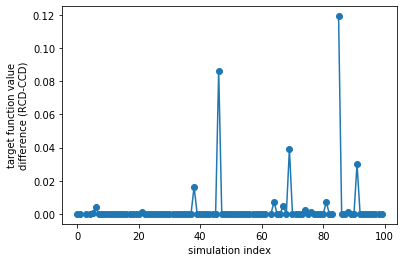

In [13]:
plt.plot(target_val['RCD']-target_val['CCD'], marker='o')
plt.xlabel('simulation index')
plt.ylabel('target function value\ndifference (RCD-CCD)')
plt.show()

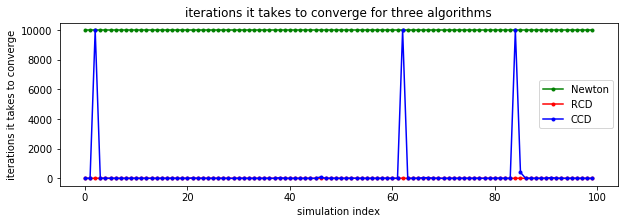

In [14]:
plt.figure(figsize=(10, 3))
plt.plot(iter_num['Newton'], label='Newton', color='g', marker='o', markersize=3)
plt.plot(iter_num['RCD'], label='RCD', color='r', marker='o', markersize=3)
plt.plot(iter_num['CCD'], label='CCD', color='b', marker='o', markersize=3)
plt.xlabel('simulation index')
plt.ylabel('iterations it takes to converge')
plt.title('iterations it takes to converge for three algorithms')
plt.legend()
plt.show()

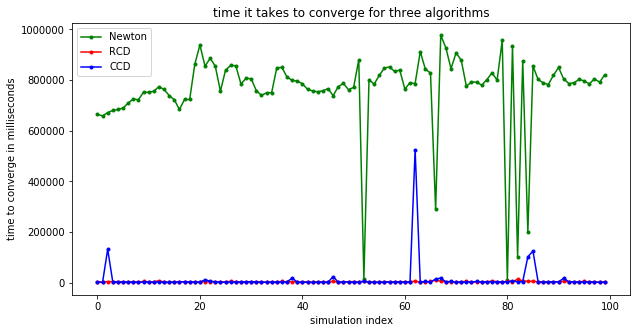

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(time['Newton'], label='Newton', color='g', marker='o', markersize=3)
plt.plot(time['RCD'], label='RCD', color='r', marker='o', markersize=3)
plt.plot(time['CCD'], label='CCD', color='b', marker='o', markersize=3)
plt.xlabel('simulation index')
plt.ylabel('time to converge in milliseconds')
plt.title('time it takes to converge for three algorithms')
plt.legend()
plt.show()

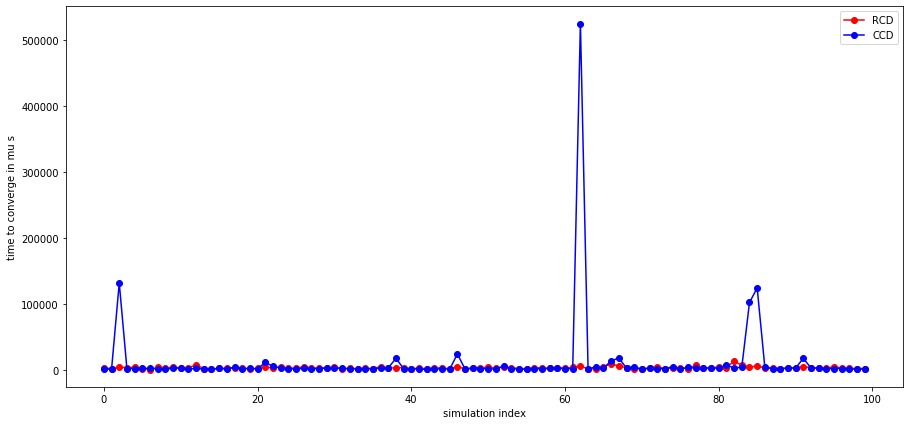

In [16]:
plt.figure(figsize=(15, 7))
plt.plot(time['RCD'], label='RCD', color='r', marker='o')
plt.plot(time['CCD'], label='CCD', color='b', marker='o')
plt.xlabel('simulation index')
plt.ylabel('time to converge in mu s')
plt.legend()
plt.show()